### Notebook for looking at van der Meer's subduction zone configurations

- Plot the total length (check it is roughly consistent with their paper
- plot successive time snapshots together to see how the interpreted lines correspond from one snapshot to the next
- extract the distance of each subduction zone segment to the nearest point on the previous snapshot subduction zone configuration - this is a (sort of) proxy for the minimum migration rate of that point (when difference in age betweent the two snapshots is taken into account). Note however that appearance and disappearance of subduction zones could cause spuriously large migration rate. 
- plot the distribution of apparent migration rates form different time snapshots

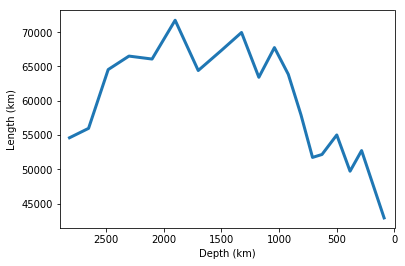

In [3]:
import pygplates
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd

%matplotlib inline

LLSVP_edge_filename = '/Users/Simon/Data/SeismicTomography/SMEAN/SMEANSLOW1'

VDM2009_slablist = ['Aegean','Mongol-Okhotsk','Farallon','Ag','Al','At','Ba','Bf','Ca','CC',\
                'Ch','EC','Eg','GI','Hi','Id','Kc','Mc','Md','Me','Mg','NP','Ro','Sa','So',
                'TA','Ve','Wc']


# Make a list of all the files that constitute the van der Meer dataset
basedir = './vanderMeerData/'
file_list = glob.glob('%s/*.shp' % basedir)

file_list.sort()

# iterate over each feature each file, and populate lists that record the different ages and 
# feature names (ie the subduction zone names)
age_list = []
depth_list = []
blen_list = []
names_list = []


VDM2009_features = []
VDM2012_features = []


for filename in file_list:
    depth = float(filename[-16:-12])
    layer_radius = pygplates.Earth.mean_radius_in_kms-depth
    inferred_age = float(filename[-9:-6])
    age_list.append(inferred_age)
    depth_list.append(depth)

    features = pygplates.FeatureCollection(filename)

    blen = 0
    for feature in features:
        btype = feature.get_shapefile_attribute('Id')
        # Based on VDM files, the attribute 'btype' is an integer denoting boundary type, where
        # 1=1st to 3rd order subduction, 4=Flat-slab subduction, 5=Other subduction
        if btype==5 or btype==1 or btype==4:
            if feature.get_geometry() is not None:
                # Length has to be corrected for different layer radii  
                blen += feature.get_geometry().get_arc_length()*layer_radius
            names_list.append(feature.get_shapefile_attribute('name'))
            
            if feature.get_shapefile_attribute('name') in VDM2009_slablist:
                feature.set_name(feature.get_shapefile_attribute('name'))
                feature.set_valid_time(inferred_age+1.,inferred_age-1.)
                VDM2009_features.append(feature)
            else:
                feature.set_name(feature.get_shapefile_attribute('name'))
                feature.set_valid_time(inferred_age+1.,inferred_age-1.)
                VDM2012_features.append(feature)

    blen_list.append(blen)
    
# make a list that contains only the 'unique' subdution zone names (no duplication)
ds = pd.Series(names_list)
unique_slab_list = ds.sort_values().unique()

# For posterity, plot the subduction zone length for each time snapshot (note - corrected for depth within Earth,
# see a few lines above) 
plt.plot(depth_list,blen_list,linewidth=3)
#plt.xlim(250,0)
plt.xlim(2900,0)
plt.xlabel('Depth (km)')
plt.ylabel('Length (km)')
plt.show()


pygplates.FeatureCollection(VDM2009_features).write('VDM2009_features.gpml')
pygplates.FeatureCollection(VDM2012_features).write('VDM2012_features.gpml')


/Users/simon/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


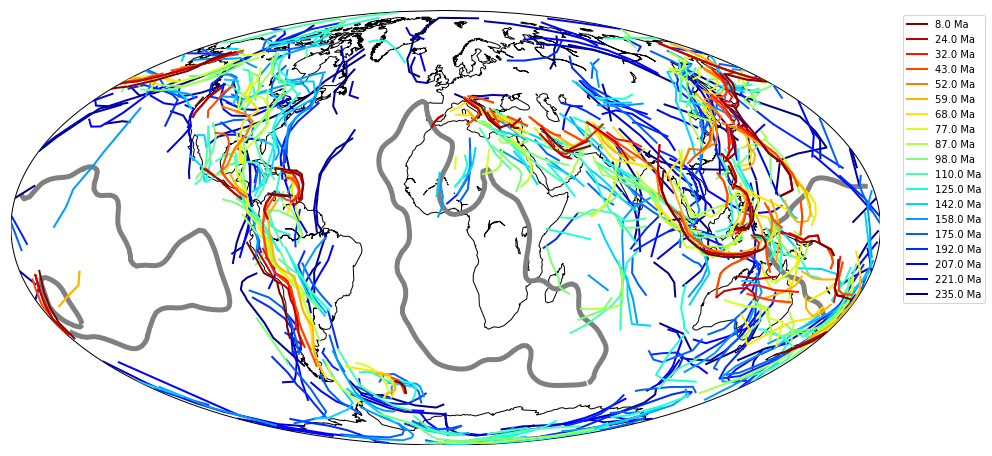

In [4]:
# Plot all subduction from different times as a single plot, color showing depth/age

plt.figure(figsize=(16,8))

m = Basemap(projection='moll',lon_0=0)
m.drawcoastlines()
m.readshapefile(LLSVP_edge_filename,'tmp',color='gray',linewidth=5,zorder=2)

color_idx = np.linspace(0, 1, len(file_list))

for i,filename in zip(color_idx,file_list):
    #dummy line plot to get legend
    plt.plot(-999,-999,color=plt.cm.jet_r(i),
             linewidth=2,label='%s Ma' % float(filename[-9:-6]))
    features = pygplates.FeatureCollection(filename)
    for feature in features:
        btype = feature.get_shapefile_attribute('Id')
        if feature.get_geometry() is not None:
            points = feature.get_geometry().to_lat_lon_array()
            if btype==5 or btype==1 or btype==4: 
                x,y = m(points[:,1],points[:,0])
                m.plot(x,y,color=plt.cm.jet_r(i),
                         linewidth=2,zorder=200-i)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()



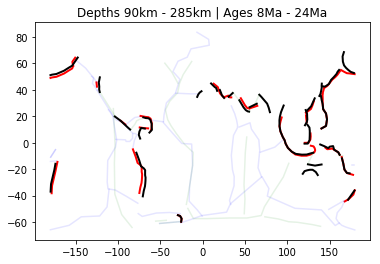

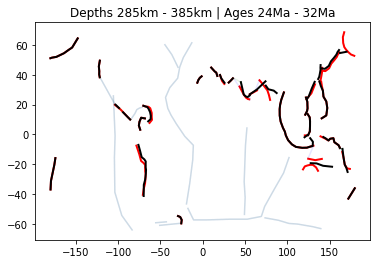

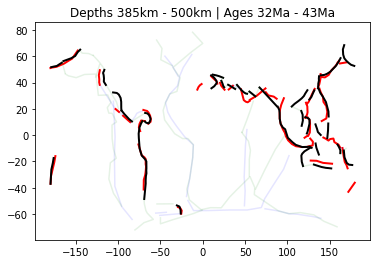

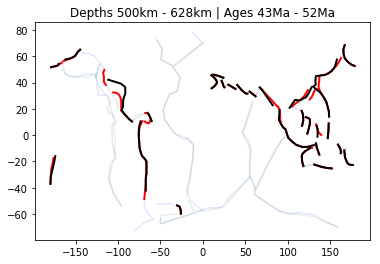

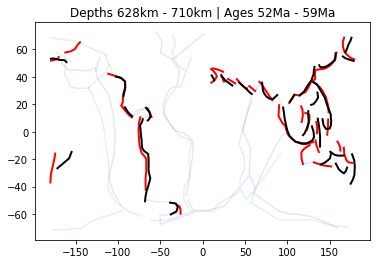

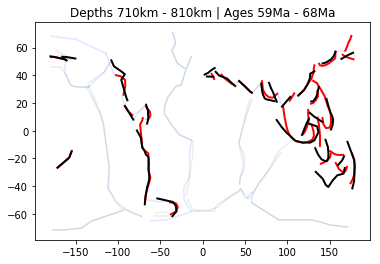

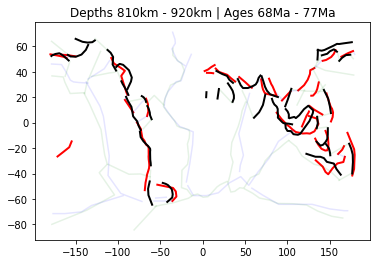

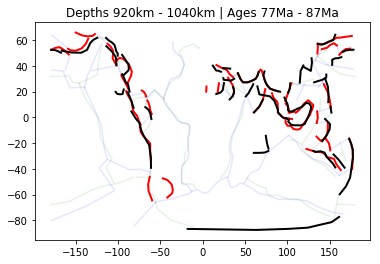

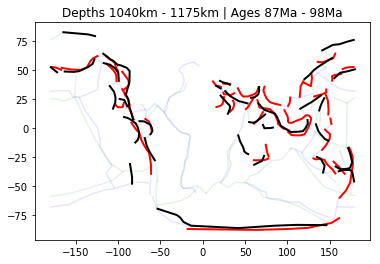

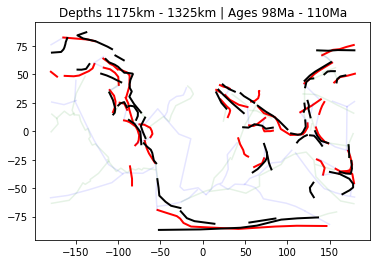

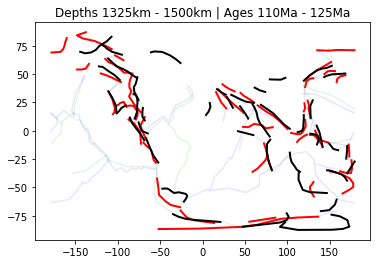

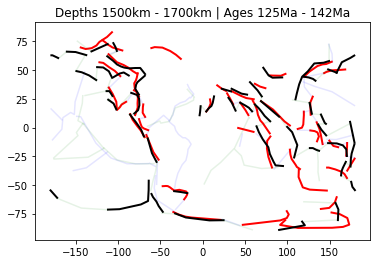

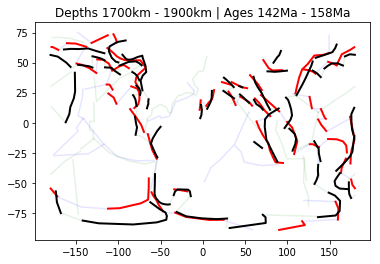

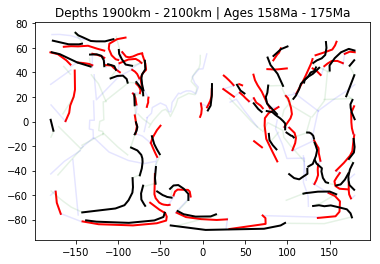

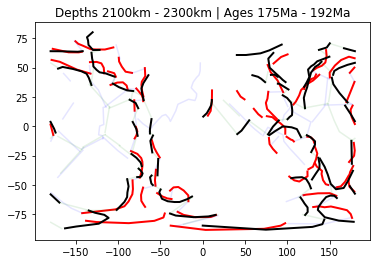

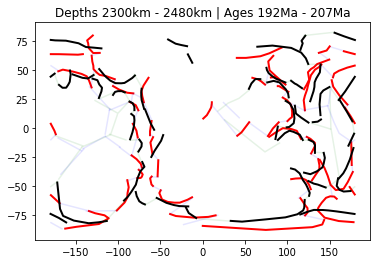

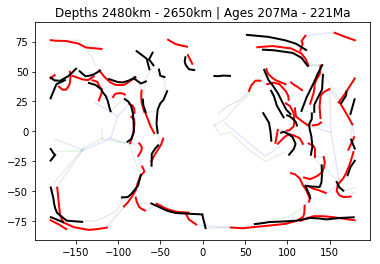

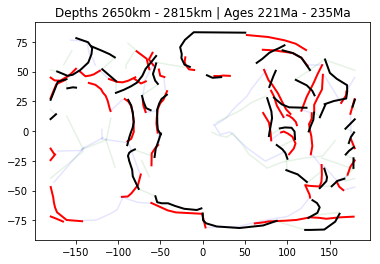

In [5]:
# For each pair of successive snapshots, plot plate boundary configuration
#(non-subduction zones are plotted faintly)
# Red is more recent, black is older of the two times

for filename1,filename2 in zip(file_list[:-1],file_list[1:]):
    #print filename
    plt.figure()
    features1 = pygplates.FeatureCollection(filename1)
    features2 = pygplates.FeatureCollection(filename2)
    for feature in features1:
        btype = feature.get_shapefile_attribute('Id')
        if feature.get_geometry() is not None:
            points = feature.get_geometry().to_lat_lon_array()
            if btype==5 or btype==1 or btype==4:        
                plt.plot(points[:,1],points[:,0],'r',linewidth=2)
            else:
                plt.plot(points[:,1],points[:,0],'b',alpha=0.1)
    for feature in features2:
        btype = feature.get_shapefile_attribute('Id')
        if feature.get_geometry() is not None:
            points = feature.get_geometry().to_lat_lon_array()
            if btype==5 or btype==1 or btype==4:        
                plt.plot(points[:,1],points[:,0],'k',linewidth=2)
            else:
                plt.plot(points[:,1],points[:,0],'g',alpha=0.1)
    plt.title('Depths %dkm - %dkm | Ages %dMa - %dMa' % \
              (float(filename1[-16:-12]),float(filename2[-16:-12]),
             float(filename1[-9:-6]),float(filename2[-9:-6])))
    plt.show()


In [10]:
# Get some files that represent the Earthbyte plate model reconstructed using the van der Meer reference frame.
# This way, we'll be able to reconstruct continent polygons to each time step, and measure the distance of each
# subduction zone to the nearest continent (at least based on the definition of continents provided by these polygons)

rotation_model = pygplates.RotationModel('/Users/Simon/Data/EByteSVN/EByteDeformingModels/Global_Model_WD_Internal_Release_2014.1_VDM2010APM/Global_EarthByte_TPW_GeeK07_2014.1_VanDerMeer_CrossoverFix.rot')
# Static polygons to determine whether subduction segment is adjacent to continent or not
static_polygon_filename = '/Users/Simon/Work/DynamicTopography/MODELS/StaticPolygons/StaticPolygonsForPlateFrame2013.2.shp'
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)

        
# Function to get distance to nearest continental polygon (should be reconstructed already)
def get_nearest_continental_polygon(seed_point,continental_polygons):
    
    min_distance_to_all_features = np.radians(180)
    nearest_continent = None        

    for polygon in continental_polygons:
        if polygon is not None:
            min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                polygon.get_reconstructed_geometry(),
                seed_point,
                min_distance_to_all_features,
                geometry1_is_solid=True)

            # If the current geometry is nearer than all previous geometries then
            # its associated feature is the nearest feature so far.
            if min_distance_to_feature is not None:
                min_distance_to_all_features = min_distance_to_feature
                nearest_continent = polygon.get_feature().get_reconstruction_plate_id()
                    
    return min_distance_to_all_features*pygplates.Earth.mean_radius_in_kms


# function that takes two successive VDM subduction networks, and compares the subduction locations in 
# each to see how far each subduction zone appears to have moved.
# Lines are tesselated to a roughly even sampling.
# Note that there are two metrics used:
# 1. Compare each subduction zone to the nearest point on ANY subduction zone in the next/previous time step
# 2. Compare each subduction zone to the nearest point on THE SAME subduction zone (based on the name assigned
#   to the line in the shapefile)
# We also return the distance to continent for each tesselated point 
# The 'name_list' specifies which subduction zone names are considered - any names not in the list are skipped
def VDM_migration(sz1,sz2,t1,t2,sz_name_list):
    
    dist2any_sz = []
    dist2same_sz = []
    szLon = []
    szLat = []
    dist2cont = []
    time_list = []
    
    time = t1
    reconstructed_continental_polygons = []
    pygplates.reconstruct(static_polygon_features,
                  rotation_model,
                  reconstructed_continental_polygons,
                  time,
                  anchor_plate_id=0)
    
    for sz in sz1:
        if sz.get_shapefile_attribute('name') in sz_name_list:
            # resample segment to a more even distribution of points
            tesselated_segment = sz.get_geometry().to_tessellated(np.radians(0.1))
            for point in tesselated_segment:
                min_distance_to_all_features = None
                min_distance_to_same_sz = None

                for prev_sz in sz2:
                    szline = prev_sz.get_geometry()
                    min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                        point,
                        szline,
                        min_distance_to_all_features)

                    # If the current geometry is nearer than all previous geometries then
                    # its associated feature is the nearest feature so far.
                    if min_distance_to_feature is not None:
                        min_distance_to_all_features = min_distance_to_feature

                    if prev_sz.get_shapefile_attribute('name')==sz.get_shapefile_attribute('name'):
                        szline = prev_sz.get_geometry()
                        min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                            point,
                            szline,
                            min_distance_to_same_sz)

                        # If the current geometry is nearer than all previous geometries then
                        # its associated feature is the nearest feature so far.
                        if min_distance_to_feature is not None:
                            min_distance_to_same_sz = min_distance_to_feature

                if min_distance_to_same_sz is None:
                    min_distance_to_same_sz = -999

                d2c = get_nearest_continental_polygon(point,reconstructed_continental_polygons)

                #print dist
                if min_distance_to_all_features is not None:
                    dist2any_sz.append(min_distance_to_all_features*pygplates.Earth.mean_radius_in_kms)
                    dist2same_sz.append(min_distance_to_same_sz*pygplates.Earth.mean_radius_in_kms)
                    szLon.append(point.to_lat_lon()[1])
                    szLat.append(point.to_lat_lon()[0])
                    dist2cont.append(d2c)
                    time_list.append(t1)
     
    #########################################################
    #### Plotting
    #########################################################
    pygplates.reconstruct(static_polygon_features, rotation_model, 'tmp.shp', time)

    fig = plt.figure(figsize=(10,4),dpi=150)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    lon0=0
    m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
    #m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
    cp = m.drawmapboundary()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,30))

    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0.5)
        plt.gca().add_patch(poly)

    #ind = np.where(np.array(dist2same_sz)>=0)
    #print ind
    #x,y = m(np.array(szLon)[ind],np.array(szLat)[ind])
    #plt.scatter(x,y,c=np.array(dist2same_sz)[ind]/(t2-t1),edgecolors='',vmin=0,vmax=100,zorder=3)
    x,y = m(np.array(szLon),np.array(szLat))
    plt.scatter(x,y,c=np.array(dist2cont),edgecolors='',vmin=0,vmax=2500,zorder=3)

    for feature in sz1:
        btype = feature.get_shapefile_attribute('Id')
        if feature.get_geometry() is not None:
            points = feature.get_geometry().to_lat_lon_array()
            x,y = m(points[:,1],points[:,0])
            plt.plot(x,y,'k',linewidth=2)

    #'''   
    for feature in sz2:
        btype = feature.get_shapefile_attribute('Id')
        if feature.get_geometry() is not None:
            points = feature.get_geometry().to_lat_lon_array()
            x,y = m(points[:,1],points[:,0])
            plt.plot(x,y,'gray',linewidth=2,alpha=0.8)
    #'''
    
    plt.colorbar()
    plt.title('Ages %s - %s Ma' % (t1,t2))
    plt.show()
            
    return szLon,szLat,np.array(dist2any_sz)/(t2-t1),np.array(dist2same_sz)/(t2-t1),dist2cont,time_list
 

./vanderMeerData/SBZ0090km_008Ma.shp


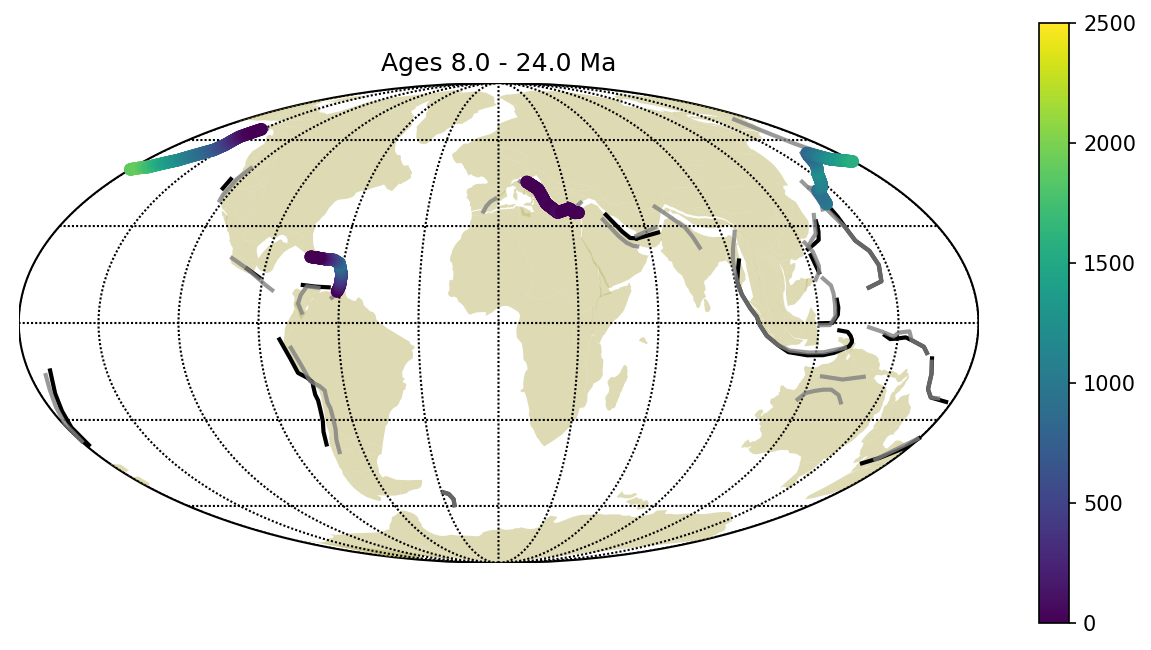

./vanderMeerData/SBZ0285km_024Ma.shp


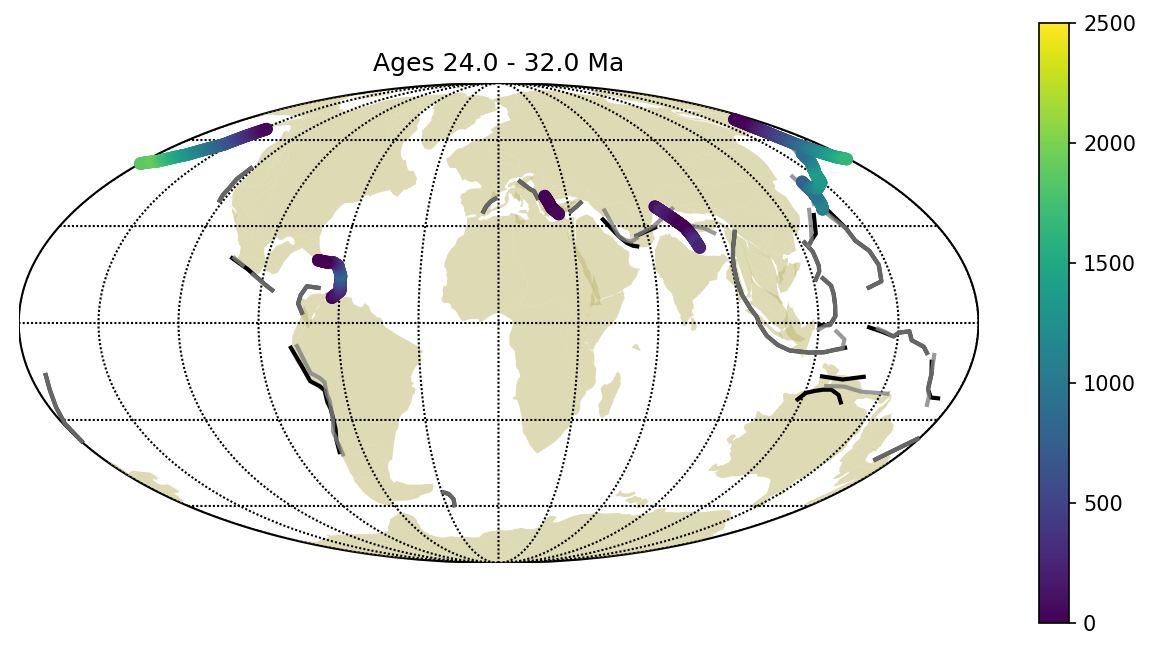

./vanderMeerData/SBZ0385km_032Ma.shp


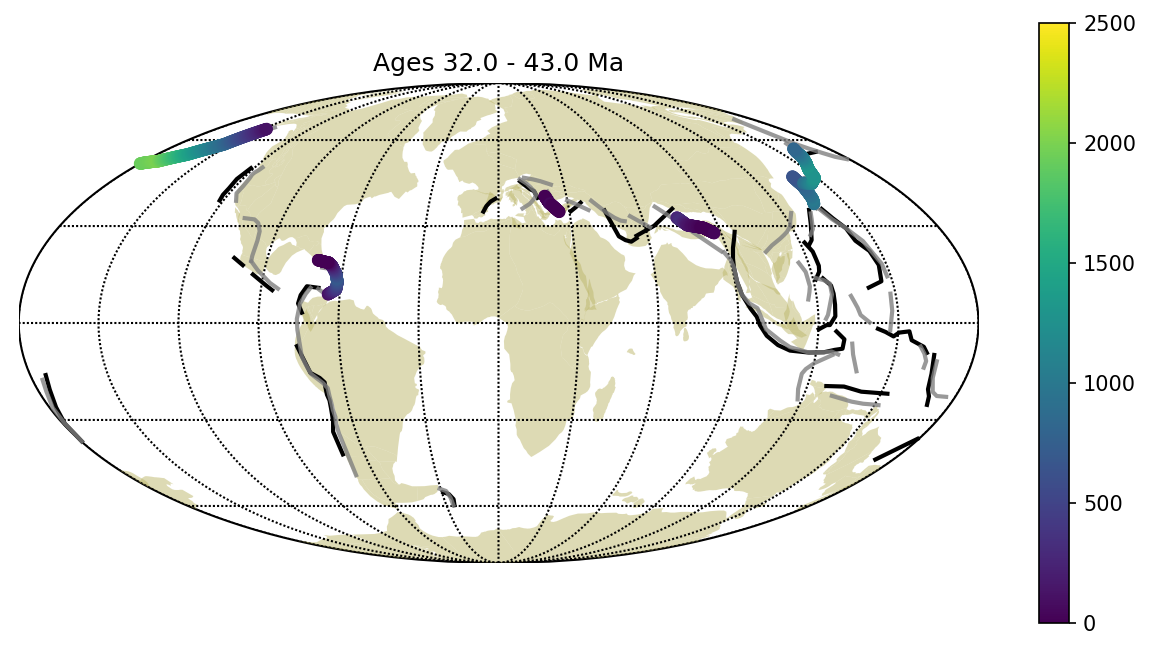

./vanderMeerData/SBZ0500km_043Ma.shp


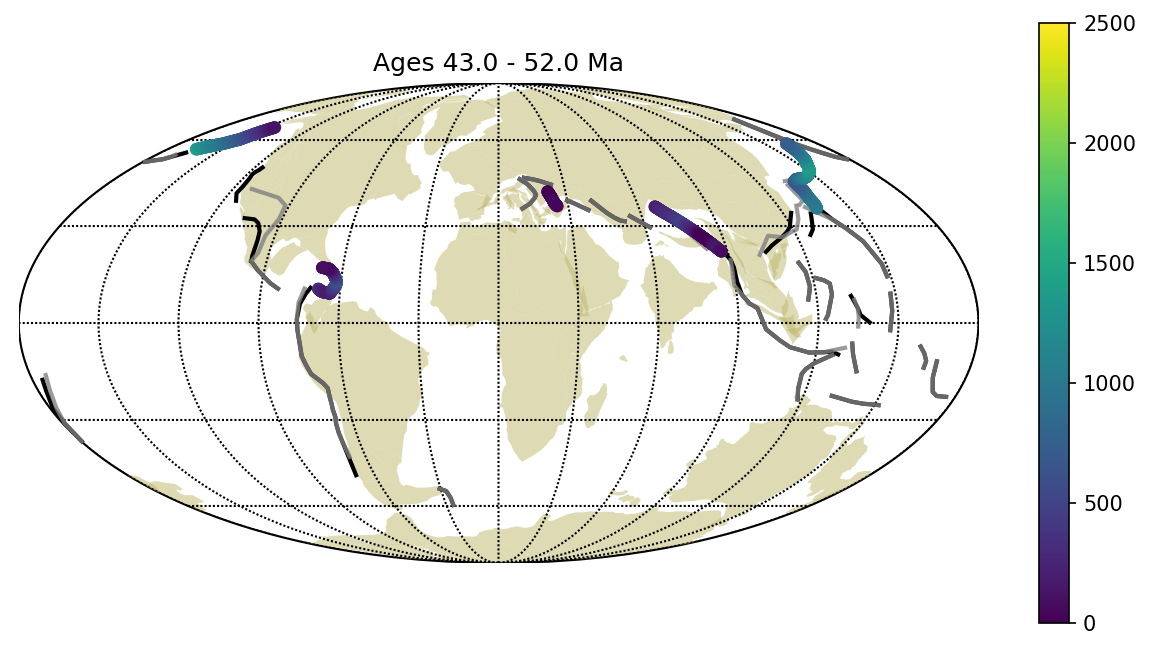

./vanderMeerData/SBZ0628km_052Ma.shp


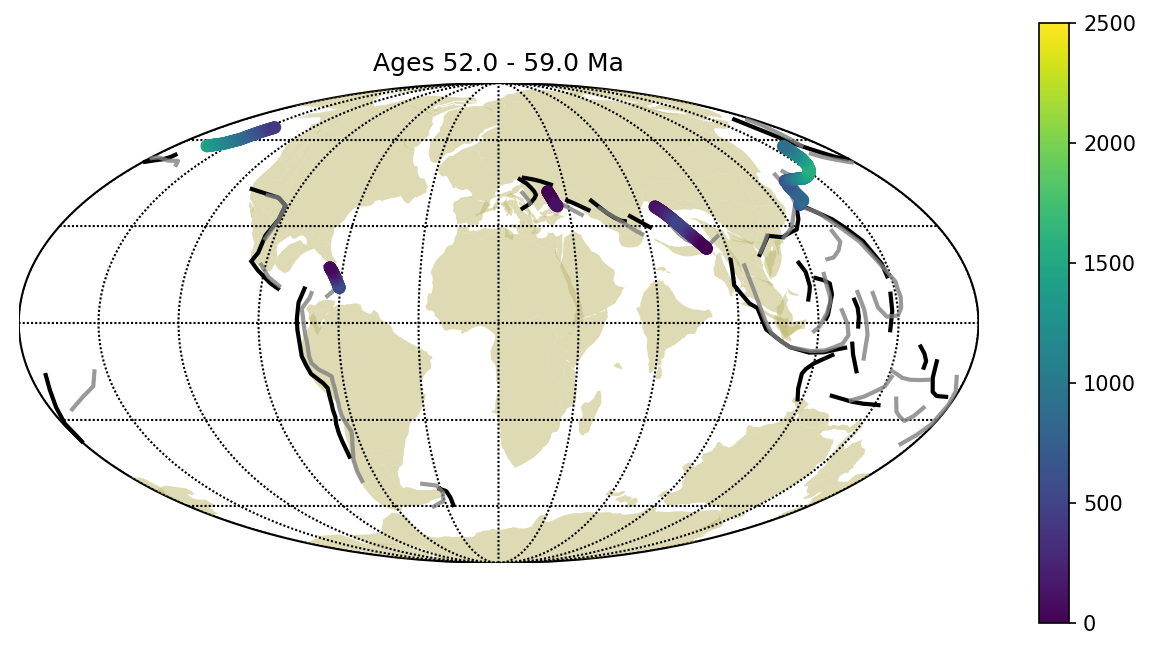

./vanderMeerData/SBZ0710km_059Ma.shp


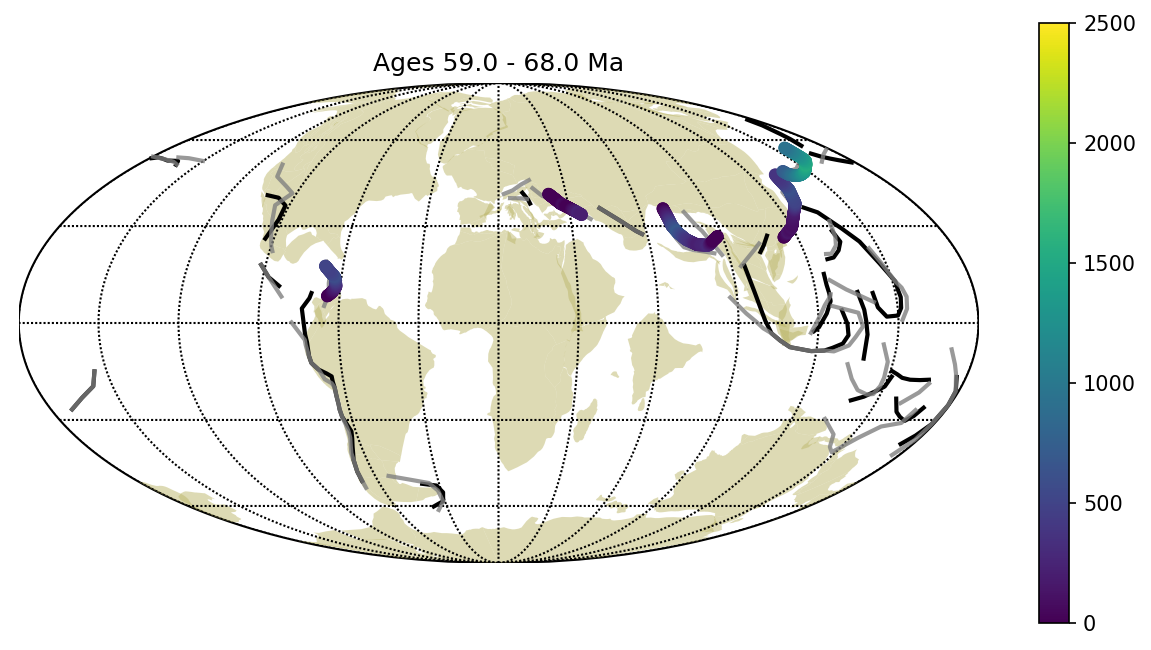

./vanderMeerData/SBZ0810km_068Ma.shp


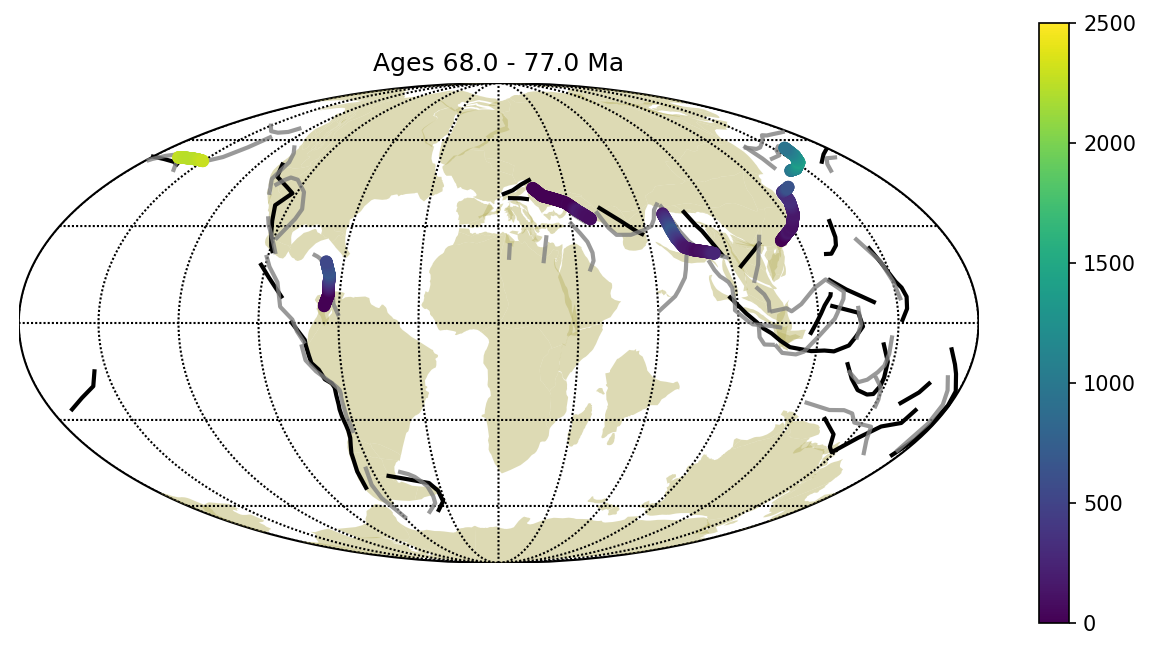

./vanderMeerData/SBZ0920km_077Ma.shp


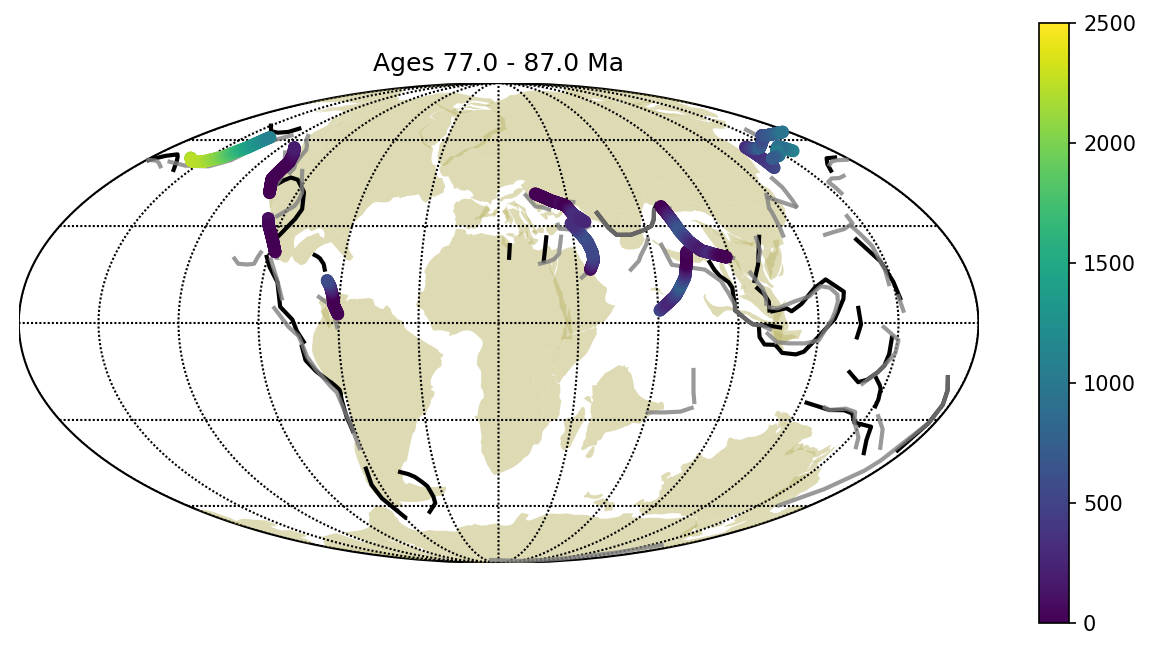

./vanderMeerData/SBZ1040km_087Ma.shp


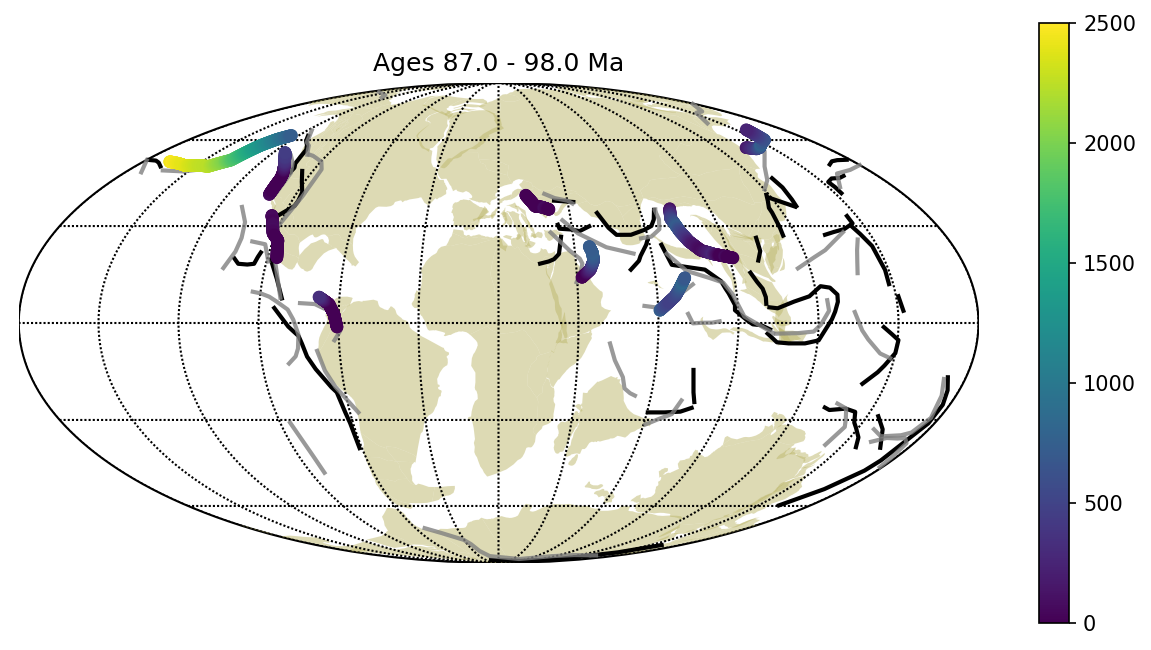

./vanderMeerData/SBZ1175km_098Ma.shp


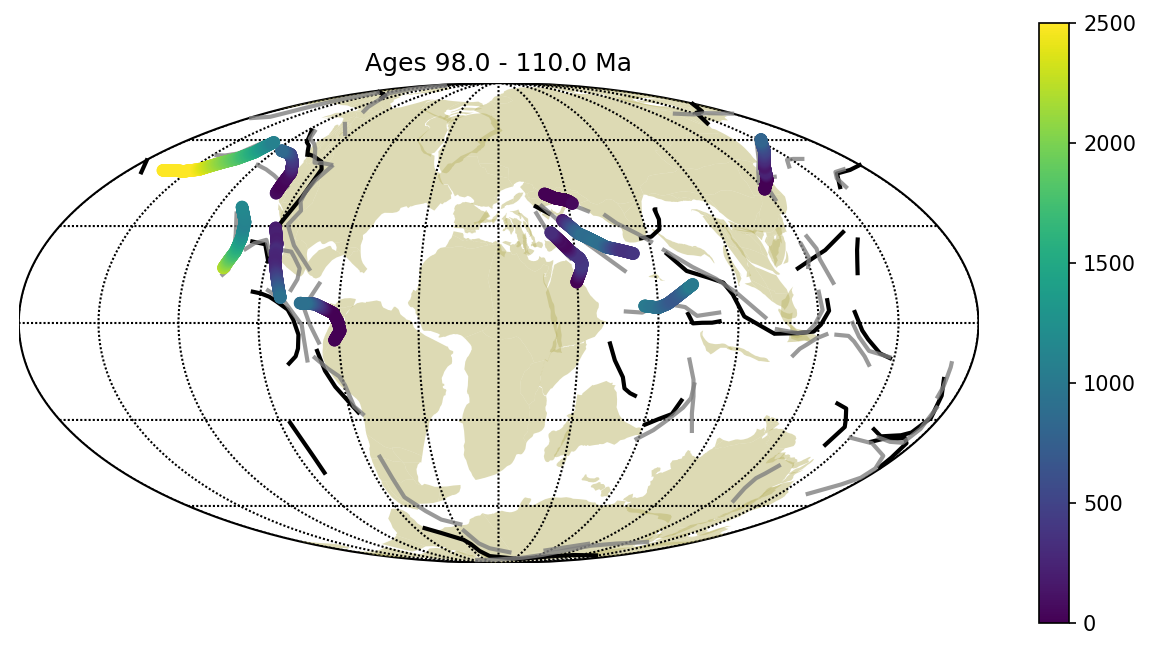

./vanderMeerData/SBZ1325km_110Ma.shp


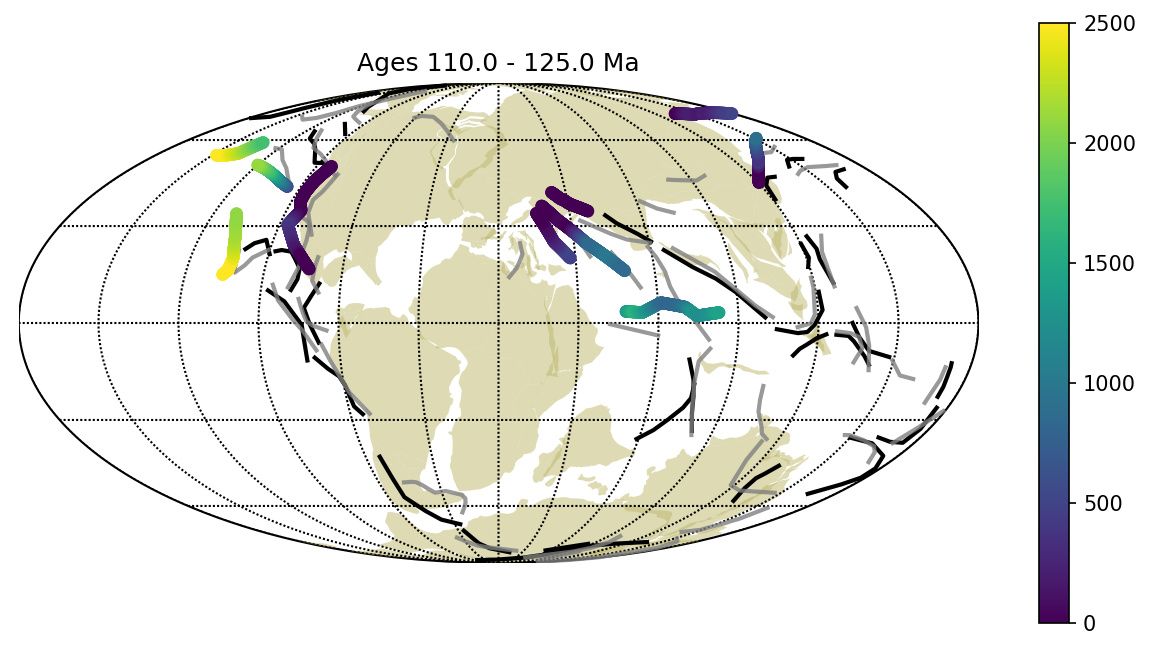

./vanderMeerData/SBZ1500km_125Ma.shp


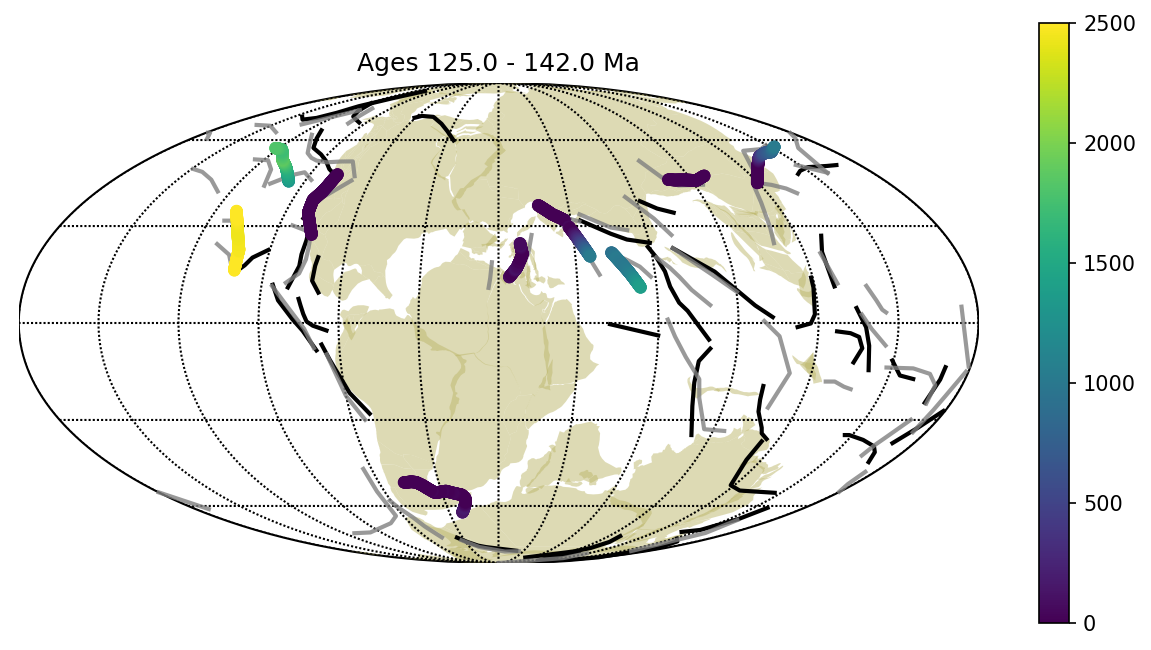

./vanderMeerData/SBZ1700km_142Ma.shp


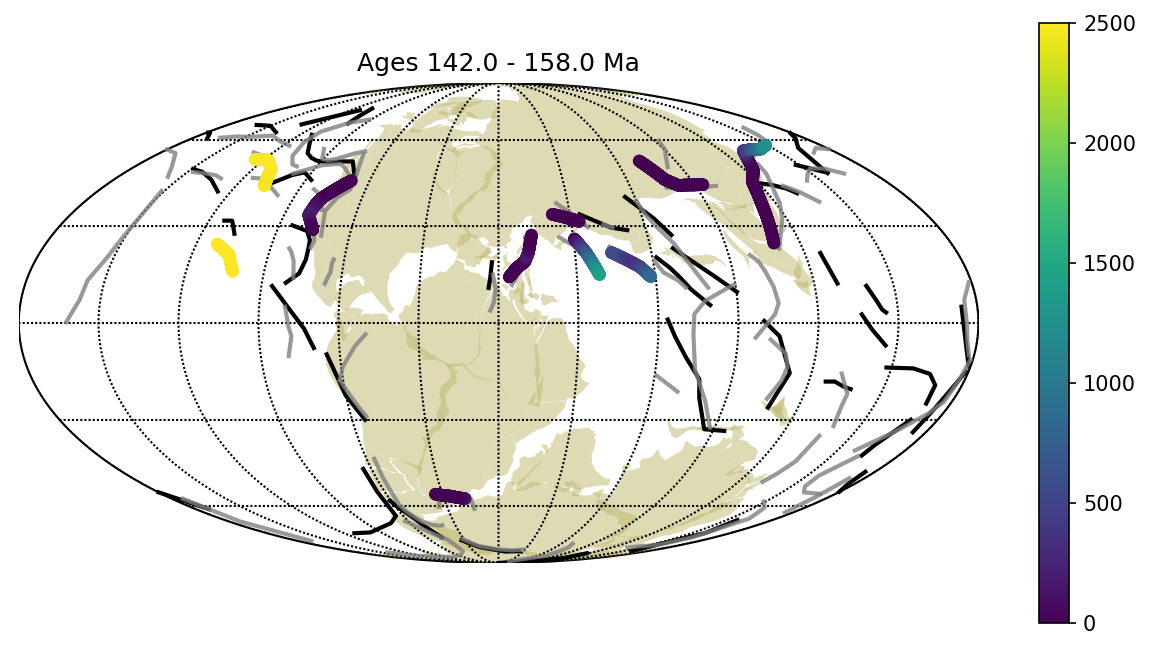

./vanderMeerData/SBZ1900km_158Ma.shp


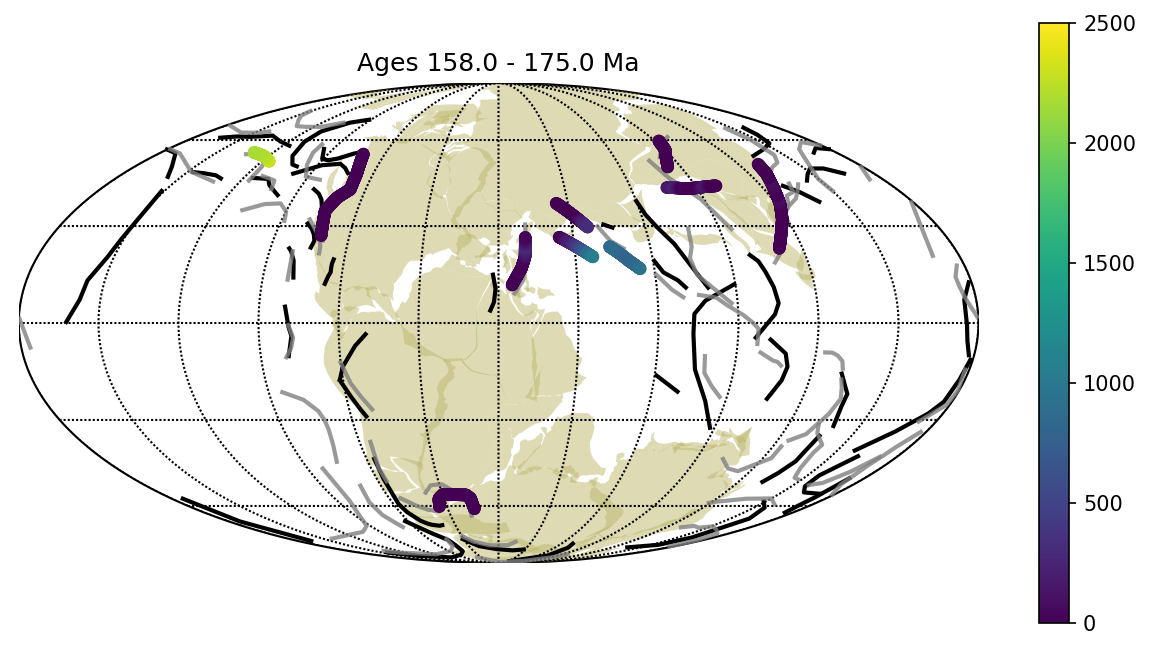

./vanderMeerData/SBZ2100km_175Ma.shp


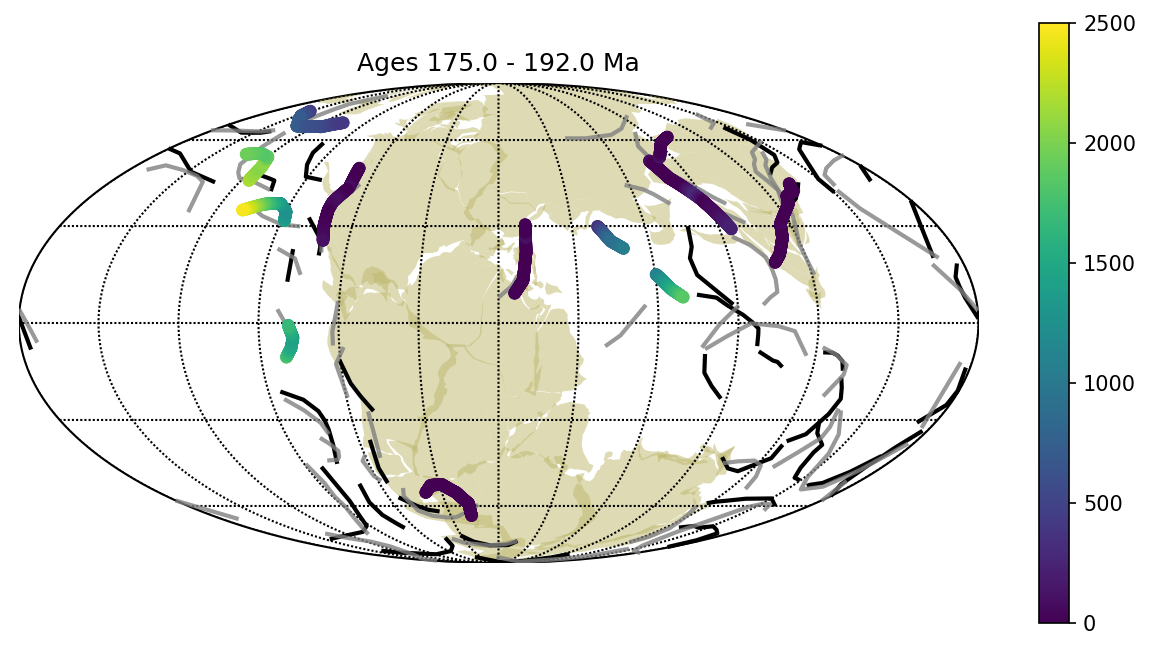

./vanderMeerData/SBZ2300km_192Ma.shp


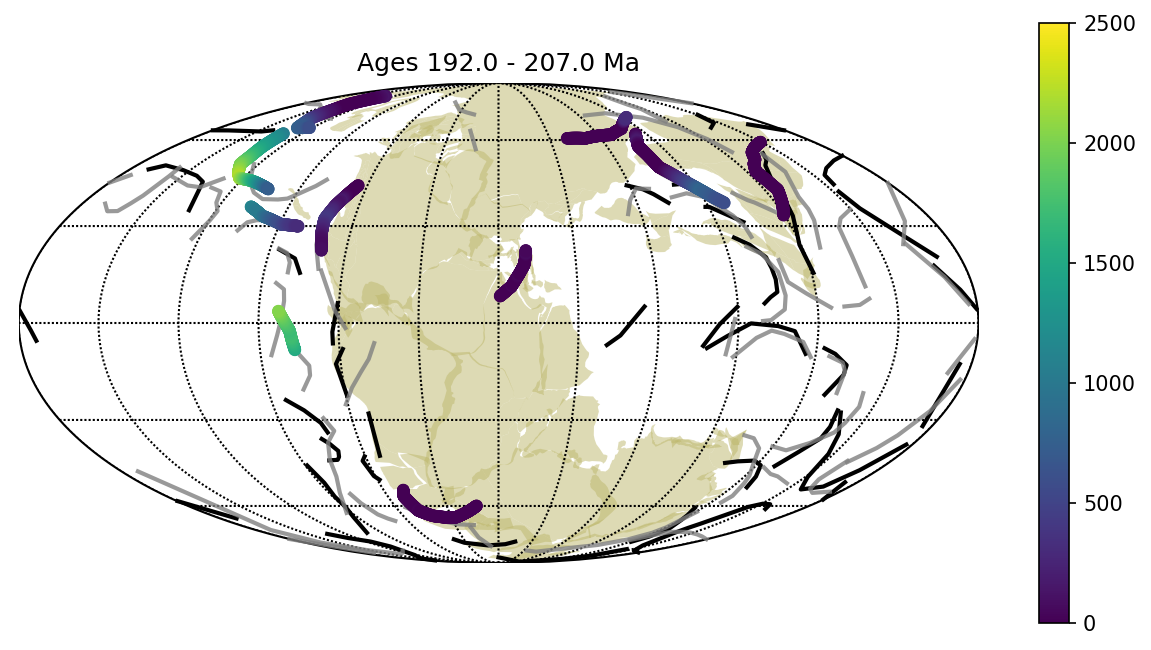

./vanderMeerData/SBZ2480km_207Ma.shp


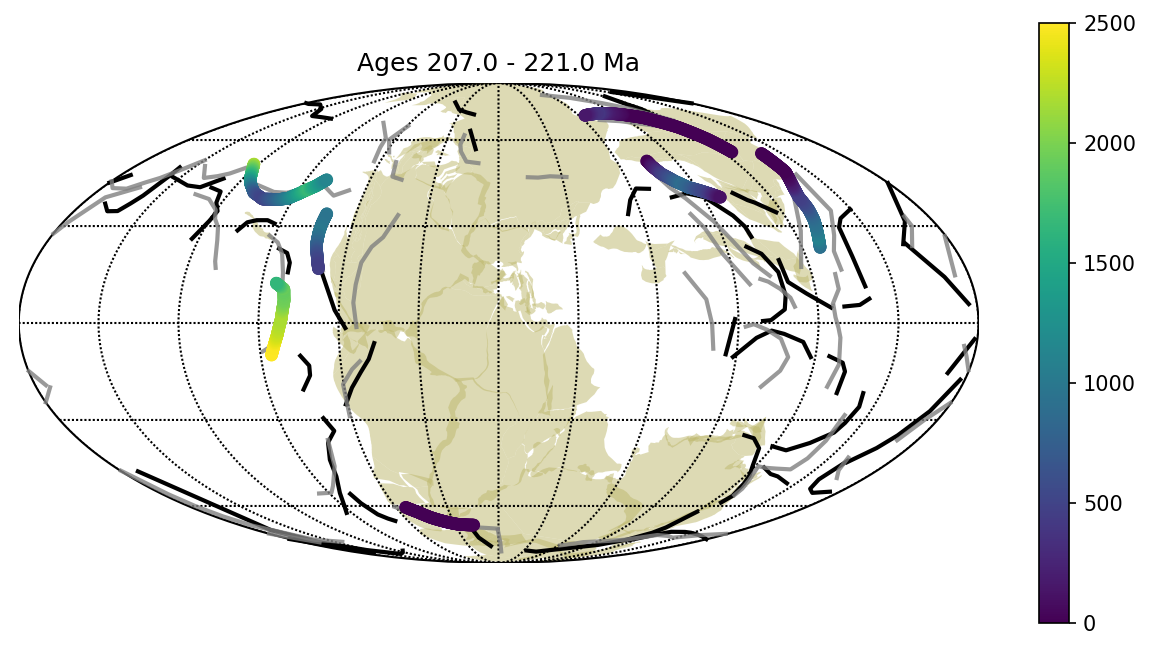

./vanderMeerData/SBZ2650km_221Ma.shp


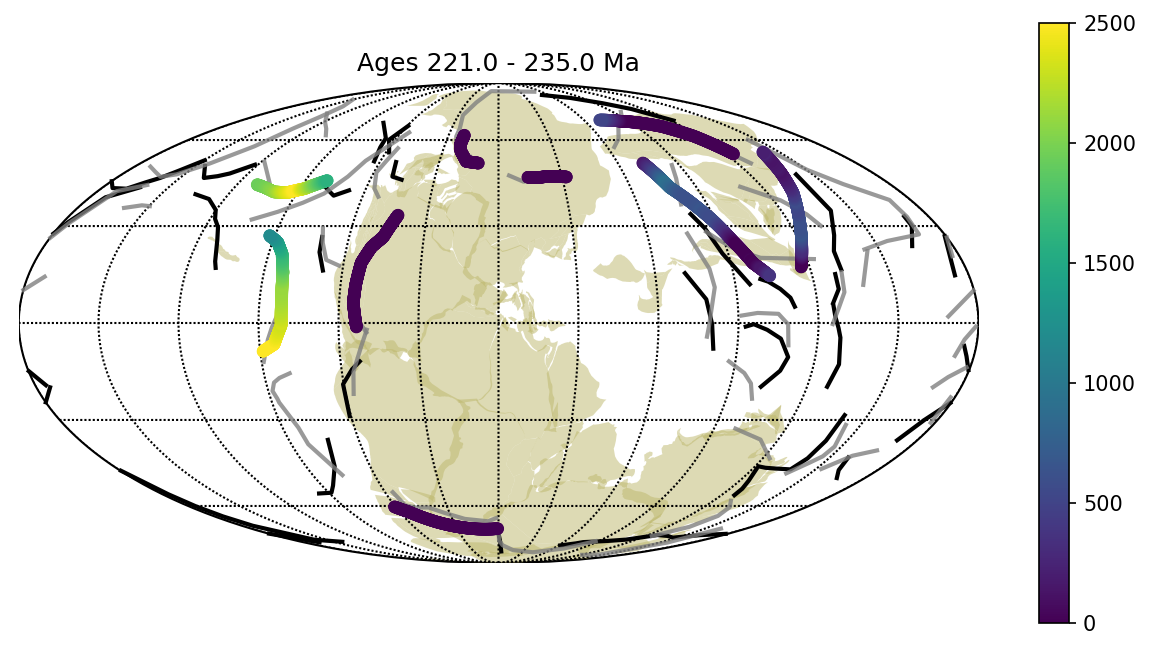

In [11]:
###########################

DataFrameTemplate = ('lon','lat','dist2AnySZ','dist2SameSZ','dist2cont','Age')
df_AllTimes = pd.DataFrame(columns=DataFrameTemplate)


VDM2009_slablist = ['Aegean','Mongol-Okhotsk','Farallon','Ag','Al','At','Ba','Bf','Ca','CC',\
                'Ch','EC','Eg','GI','Hi','Id','Kc','Mc','Md','Me','Mg','NP','Ro','Sa','So',
                'TA','Ve','Wc']

#slabs_to_include = unique_slab_list
slabs_to_include = VDM2009_slablist


for filename1,filename2 in zip(file_list[:-1],file_list[1:]):

    print filename1
    
    sz1 = []
    features1 = pygplates.FeatureCollection(filename1)
    for feature in features1:
        btype = feature.get_shapefile_attribute('Id')
        if btype==5 or btype==1 or btype==4:
            if feature.get_geometry() is not None:
                sz1.append(feature)
                   
    sz2 = []
    features2 = pygplates.FeatureCollection(filename2)   
    for feature in features2:
        btype = feature.get_shapefile_attribute('Id')
        if btype==5 or btype==1 or btype==4:
            if feature.get_geometry() is not None:
                sz2.append(feature)
           
    szLon,szLat,dist2any,dist2same,dist2c,timel = VDM_migration(sz1,
                                                                sz2,
                                                                float(filename1[-9:-6]),
                                                                float(filename2[-9:-6]),
                                                                slabs_to_include)      
    
    szdata=[]
    for item in zip(szLon,szLat,dist2any,dist2same,dist2c,timel):
        szdata.append(item)
    df = pd.DataFrame(szdata, columns = DataFrameTemplate)
    
    df_AllTimes = df_AllTimes.append(df)
    
    
    #plt.figure(figsize=(10,4))
    #plt.scatter(szLon,szLat,c=dist2c,edgecolors='',vmin=0,vmax=5000)
    #plt.colorbar()
    #plt.title('Ages %s - %s Ma' % (float(filename1[-9:-6]),float(filename2[-9:-6])))
    #plt.show()

#df_AllTimes.to_csv('./VDM_subduction_distances.csv')    
df_AllTimes.to_csv('./VDM_subduction_distances_2009list.csv')    
